# 🏈 Super Bowl LX Prediction
## Seattle Seahawks vs New England Patriots
### XGBoost Binary Classification

---

**Goal:** Find Super Bowl winning TRENDS based on rankings, then predict SB LX

**Features:** Conference, Off Rank, Def Rank, Wins

**Training Data:** Super Bowls XXXV (2000) – LIX (2025) = 50 rows

---
## 1. Import Libraries

In [49]:
from google.colab import userdata
import os
userdata.get('AWS_ACCESS_KEY_ID')
userdata.get('AWS_SECRET_ACCESS_KEY')
os.environ['AWS_ACCESS_KEY_ID'] = userdata.get('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get('AWS_SECRET_ACCESS_KEY')

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✓ Libraries imported successfully!')

✓ Libraries imported successfully!


---
## 2. Load Data from S3

In [50]:
df = pd.read_csv('s3://person-project/superbowl_historical_data.csv')

print(f'Dataset: {len(df)} rows, {len(df.columns)} columns')
print(f'Super Bowls covered: {df["year"].min()} - {df["year"].max()}')
print(f'Winners: {df["won"].sum()} | Losers: {(df["won"]==0).sum()}')
print()
df

Dataset: 50 rows, 7 columns
Super Bowls covered: 2000 - 2024
Winners: 25 | Losers: 25



,team,year,conference,off_rank,def_rank,wins,won
0,BAL,2000,AFC,14,1,12,1
1,NYG,2000,NFC,15,5,12,0
2,NE,2001,AFC,6,6,11,1
3,STL,2001,NFC,1,7,14,0
4,OAK,2002,AFC,2,6,11,0
5,TB,2002,NFC,18,1,12,1
6,NE,2003,AFC,12,1,14,1
7,CAR,2003,NFC,15,10,11,0
8,NE,2004,AFC,4,2,14,1
9,PHI,2004,NFC,8,2,13,0


---
## 3. Data Exploration

In [51]:
# Basic stats
print('=== DATA SUMMARY ===')
print(df.describe())
print()
print('=== CLASS BALANCE ===')
print(df['won'].value_counts())
print()
print('=== CONFERENCE BALANCE ===')
print(df['conference'].value_counts())
print()
print('=== WINS BY CONFERENCE ===')
print(df.groupby('conference')['won'].sum())

=== DATA SUMMARY ===
              year   off_rank   def_rank       wins        won
count    50.000000  50.000000  50.000000  50.000000  50.000000
mean   2012.000000   7.500000   7.980000  12.460000   0.500000
std       7.284314   5.877144   7.549807   1.897474   0.505076
min    2000.000000   1.000000   1.000000   9.000000   0.000000
25%    2006.000000   3.000000   2.000000  11.000000   0.000000
50%    2012.000000   6.500000   6.000000  12.000000   0.500000
75%    2018.000000  11.750000  10.000000  13.750000   1.000000
max    2024.000000  23.000000  28.000000  20.000000   1.000000

=== CLASS BALANCE ===
won
1    25
0    25
Name: count, dtype: int64

=== CONFERENCE BALANCE ===
conference
AFC    25
NFC    25
Name: count, dtype: int64

=== WINS BY CONFERENCE ===
conference
AFC    15
NFC    10
Name: won, dtype: int64


In [52]:
# Winners vs Losers comparison
winners = df[df['won'] == 1]
losers = df[df['won'] == 0]

print('=== WINNERS vs LOSERS ===')
print(f'{"Stat":<20s} {"Winners":<12s} {"Losers":<12s} {"Difference"}')
print('-' * 56)

for col in ['off_rank', 'def_rank', 'wins']:
    w_avg = winners[col].mean()
    l_avg = losers[col].mean()
    diff = w_avg - l_avg
    print(f'{col:<20s} {w_avg:<12.1f} {l_avg:<12.1f} {diff:+.1f}')

print()
print('💡 Lower off_rank/def_rank = BETTER (rank 1 is best)')
print('💡 Winners have better def_rank on average - defense matters!')
print('💡 Wins are nearly identical - regular season wins dont predict much!')

=== WINNERS vs LOSERS ===
Stat                 Winners      Losers       Difference
--------------------------------------------------------
off_rank             8.9          6.1          +2.8
def_rank             6.6          9.4          -2.8
wins                 12.3         12.6         -0.4

💡 Lower off_rank/def_rank = BETTER (rank 1 is best)
💡 Winners have better def_rank on average - defense matters!
💡 Wins are nearly identical - regular season wins dont predict much!


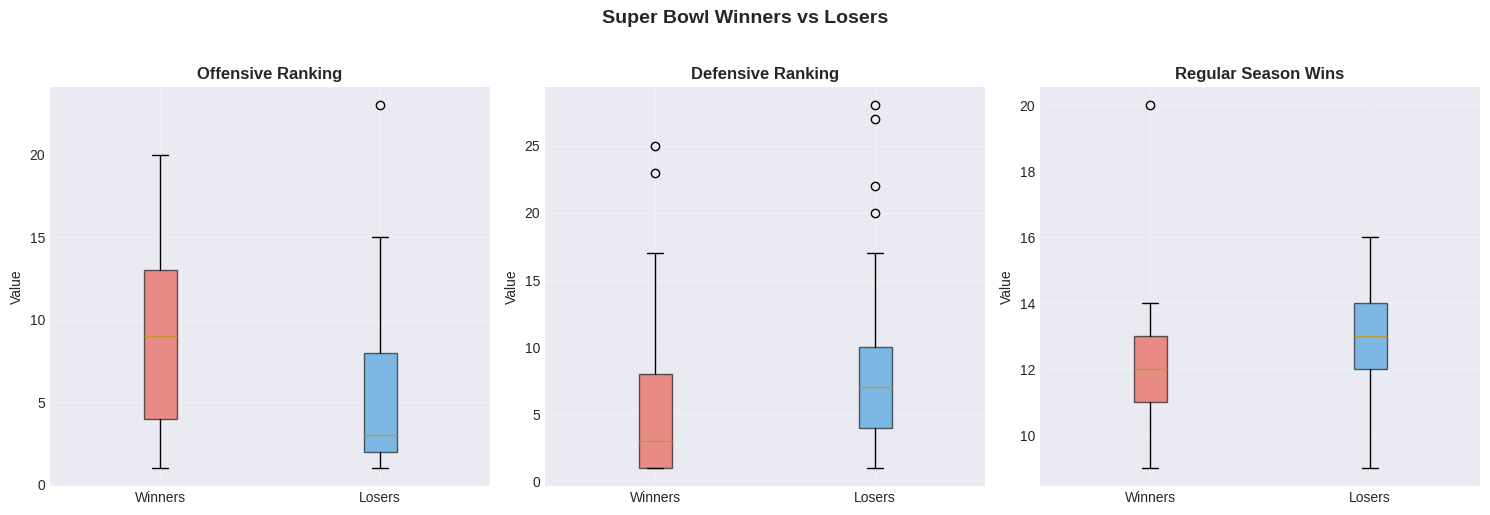

In [53]:
# Visualize Winners vs Losers
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

cols = ['off_rank', 'def_rank', 'wins']
titles = ['Offensive Ranking', 'Defensive Ranking', 'Regular Season Wins']
colors = ['#e74c3c', '#3498db']

for ax, col, title in zip(axes, cols, titles):
    data_to_plot = [winners[col], losers[col]]
    bp = ax.boxplot(
        data_to_plot,
        labels=['Winners', 'Losers'],
        patch_artist=True
    )
    bp['boxes'][0].set_facecolor('#e74c3c')
    bp['boxes'][0].set_alpha(0.6)
    bp['boxes'][1].set_facecolor('#3498db')
    bp['boxes'][1].set_alpha(0.6)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.suptitle('Super Bowl Winners vs Losers', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [54]:
# How often does the team with FEWER wins actually win?
upsets = 0
total = 0
upset_list = []

for year in df['year'].unique():
    subset = df[df['year'] == year]
    winner = subset[subset['won'] == 1]
    loser = subset[subset['won'] == 0]
    total += 1
    if winner['wins'].values[0] < loser['wins'].values[0]:
        upsets += 1
        upset_list.append(f"{winner['team'].values[0]} ({winner['wins'].values[0]}W) beat {loser['team'].values[0]} ({loser['wins'].values[0]}W) in {year}")

print(f'=== UPSETS (fewer regular season wins but won SB) ===')
print(f'{upsets} out of {total} Super Bowls ({upsets/total*100:.0f}%) were "upsets" by wins\n')
for u in upset_list:
    print(f'  • {u}')

print(f'\n💡 Regular season wins are NOT a strong predictor!')

=== UPSETS (fewer regular season wins but won SB) ===
12 out of 25 Super Bowls (48%) were "upsets" by wins

  • NE (11W) beat STL (14W) in 2001
  • PIT (11W) beat SEA (13W) in 2005
  • IND (12W) beat CHI (13W) in 2006
  • NYG (10W) beat NE (16W) in 2007
  • GB (10W) beat PIT (12W) in 2010
  • NYG (9W) beat NE (13W) in 2011
  • BAL (10W) beat SF (11W) in 2012
  • DEN (12W) beat CAR (15W) in 2015
  • NE (11W) beat LAR (13W) in 2018
  • TB (11W) beat KC (14W) in 2020
  • KC (11W) beat SF (12W) in 2023
  • PHI (14W) beat KC (15W) in 2024

💡 Regular season wins are NOT a strong predictor!


---
## 4. Preprocessing

In [55]:
# Encode conference
le = LabelEncoder()
df['conference_encoded'] = le.fit_transform(df['conference'])
print(f'Conference encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}')

# Define features and target
feature_columns = ['conference_encoded', 'off_rank', 'def_rank', 'wins']
X = df[feature_columns]
y = df['won']

print(f'\nFeatures (X): {X.shape}')
print(f'Target (y): {y.shape}')
print(f'\nFeature matrix:')
X

Conference encoding: {'AFC': np.int64(0), 'NFC': np.int64(1)}

Features (X): (50, 4)
Target (y): (50,)

Feature matrix:


,conference_encoded,off_rank,def_rank,wins
0,0,14,1,12
1,1,15,5,12
2,0,6,6,11
3,1,1,7,14
4,0,2,6,11
5,1,18,1,12
6,0,12,1,14
7,1,15,10,11
8,0,4,2,14
9,1,8,2,13


---
## 5. Train-Test Split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f'Training: {len(X_train)} rows')
print(f'Testing:  {len(X_test)} rows')
print(f'\nTraining class balance:')
print(y_train.value_counts())

Training: 35 rows
Testing:  15 rows

Training class balance:
won
1    18
0    17
Name: count, dtype: int64


---
## 6. GridSearchCV - Find Best Hyperparameters

In [57]:
# Toggle on/off
use_gridsearch = True  # Set False to skip and use defaults

if use_gridsearch:
    print('Running GridSearchCV...')
    print('Testing combinations to find optimal hyperparameters...\n')

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [2, 3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1, 0.3],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'min_child_weight': [1, 3, 5]
    }

    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        use_label_encoder=False
    )

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_

    print('\n=== BEST HYPERPARAMETERS ===')
    for param, value in grid_search.best_params_.items():
        print(f'  {param}: {value}')
    print(f'\nBest CV Accuracy: {grid_search.best_score_:.3f}')

else:
    print('Using default hyperparameters...')
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        use_label_encoder=False
    )
    model.fit(X_train, y_train)
    print('✓ Model trained!')

Running GridSearchCV...
Testing combinations to find optimal hyperparameters...

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits

=== BEST HYPERPARAMETERS ===
  colsample_bytree: 0.8
  learning_rate: 0.01
  max_depth: 2
  min_child_weight: 3
  n_estimators: 100
  subsample: 1.0

Best CV Accuracy: 0.629


---
## 7. Model Evaluation

In [58]:
# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print('=== MODEL PERFORMANCE ===')
print(f'Accuracy:  {accuracy_score(y_test, y_pred):.3f}')
print(f'ROC-AUC:   {roc_auc_score(y_test, y_pred_proba):.3f}')
print()
print(classification_report(y_test, y_pred, target_names=['Loss', 'Win']))

=== MODEL PERFORMANCE ===
Accuracy:  0.600
ROC-AUC:   0.705

              precision    recall  f1-score   support

        Loss       0.67      0.50      0.57         8
         Win       0.56      0.71      0.62         7

    accuracy                           0.60        15
   macro avg       0.61      0.61      0.60        15
weighted avg       0.61      0.60      0.60        15



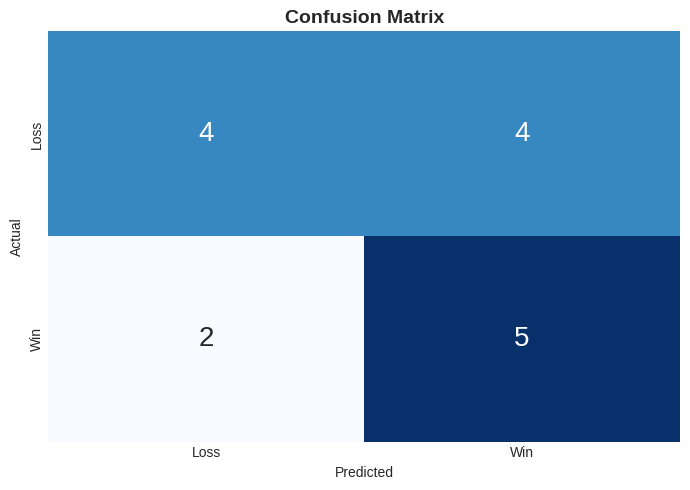

In [59]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'],
            annot_kws={'size': 20})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

=== 5-FOLD CROSS-VALIDATION ===
  Fold 1: 0.500
  Fold 2: 0.800
  Fold 3: 0.700
  Fold 4: 0.600
  Fold 5: 0.600

  Mean:  0.640
  Std:   0.102


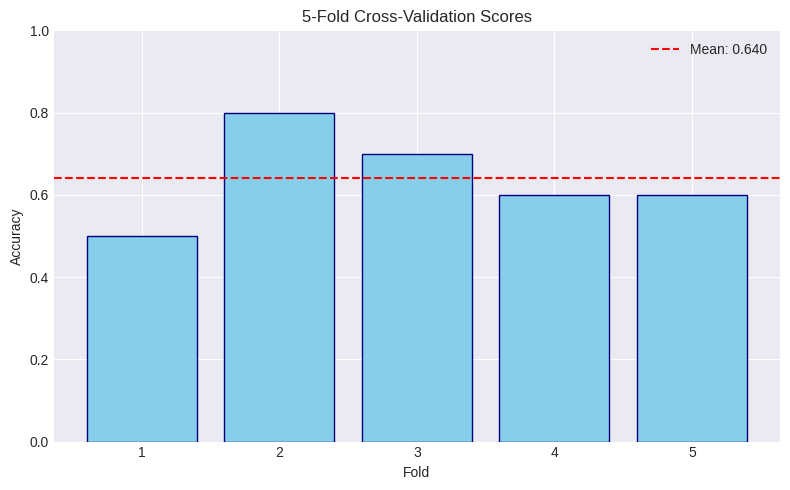

In [60]:
# Cross-Validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print('=== 5-FOLD CROSS-VALIDATION ===')
for i, score in enumerate(cv_scores, 1):
    print(f'  Fold {i}: {score:.3f}')
print(f'\n  Mean:  {cv_scores.mean():.3f}')
print(f'  Std:   {cv_scores.std():.3f}')

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(range(1, 6), cv_scores, color='skyblue', edgecolor='navy')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.3f}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Scores')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

---
## 8. Feature Importance

=== FEATURE IMPORTANCE ===
What matters most for winning the Super Bowl?

  1. Defensive Ranking         0.3665 (36.6%)
  2. Offensive Ranking         0.3519 (35.2%)
  3. Conference (NFC/AFC)      0.2817 (28.2%)
  4. Regular Season Wins       0.0000 (0.0%)


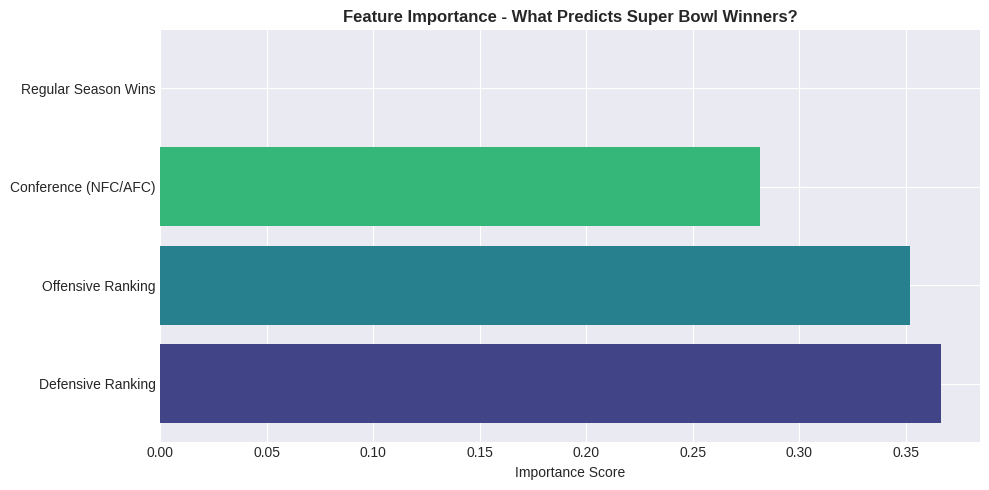

In [61]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

readable = {
    'conference_encoded': 'Conference (NFC/AFC)',
    'off_rank': 'Offensive Ranking',
    'def_rank': 'Defensive Ranking',
    'wins': 'Regular Season Wins'
}

print('=== FEATURE IMPORTANCE ===')
print('What matters most for winning the Super Bowl?\n')
for i, idx in enumerate(indices):
    feat = feature_columns[idx]
    print(f'  {i+1}. {readable[feat]:<25s} {importances[idx]:.4f} ({importances[idx]*100:.1f}%)')

# Plot
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(importances)))
labels = [readable[feature_columns[i]] for i in indices]

plt.figure(figsize=(10, 5))
plt.barh(range(len(importances)), importances[indices], color=colors)
plt.yticks(range(len(importances)), labels)
plt.xlabel('Importance Score')
plt.title('Feature Importance - What Predicts Super Bowl Winners?', fontweight='bold')
plt.tight_layout()
plt.show()

---
## 9. Super Bowl LX Prediction
### Seattle Seahawks vs New England Patriots

In [62]:
seahawks = {
    'conference_encoded': le.transform(['NFC'])[0],
    'off_rank': 3,       # TODO: actual 2025 off_rank
    'def_rank': 1,       # TODO: actual 2025 def_rank (they have #1 defense!)
    'wins': 14           # TODO: actual 2025 wins (14-3 record)
}

patriots = {
    'conference_encoded': le.transform(['AFC'])[0],
    'off_rank': 2,      # TODO: actual 2025 off_rank
    'def_rank': 4,       # TODO: actual 2025 def_rank
    'wins': 14           # TODO: actual 2025 wins (14-3 record)
}

# Convert to DataFrames
seahawks_df = pd.DataFrame([seahawks])[feature_columns]
patriots_df = pd.DataFrame([patriots])[feature_columns]

# Predict
sea_prob = model.predict_proba(seahawks_df)[0]
ne_prob = model.predict_proba(patriots_df)[0]

print('=' * 50)
print('   SUPER BOWL LX PREDICTION')
print('   Seahawks (NFC) vs Patriots (AFC)')
print('=' * 50)
print(f'\n  Seattle Seahawks:')
print(f'    Win Probability:  {sea_prob[1]:.1%}')
print(f'\n  New England Patriots:')
print(f'    Win Probability:  {ne_prob[1]:.1%}')
print()
print('=' * 50)
if sea_prob[1] > ne_prob[1]:
    print(f'  🏆 PREDICTED WINNER: Seattle Seahawks')
    print(f'     Confidence Edge: {(sea_prob[1] - ne_prob[1]):.1%}')
else:
    print(f'  🏆 PREDICTED WINNER: New England Patriots')
    print(f'     Confidence Edge: {(ne_prob[1] - sea_prob[1]):.1%}')
print('=' * 50)

   SUPER BOWL LX PREDICTION
   Seahawks (NFC) vs Patriots (AFC)

  Seattle Seahawks:
    Win Probability:  51.6%

  New England Patriots:
    Win Probability:  56.7%

  🏆 PREDICTED WINNER: New England Patriots
     Confidence Edge: 5.1%


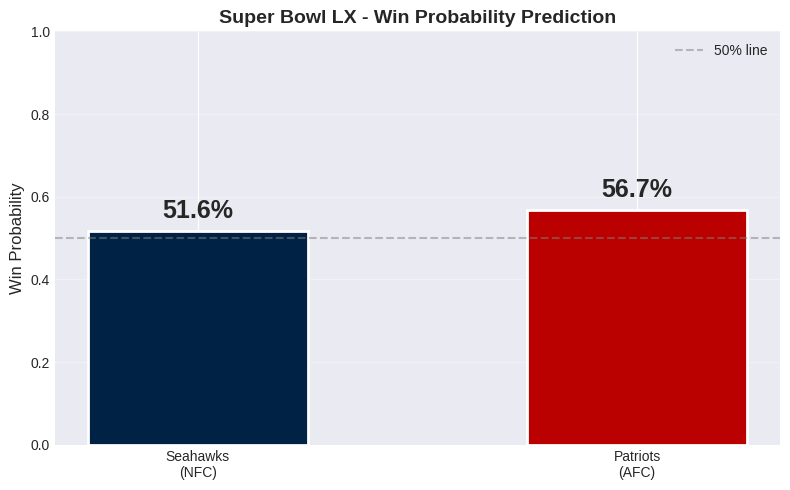

In [63]:
# Visualize prediction
teams = ['Seahawks\n(NFC)', 'Patriots\n(AFC)']
probs = [sea_prob[1], ne_prob[1]]
colors_pred = ['#002244', '#BB0000']

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(teams, probs, color=colors_pred, width=0.5, edgecolor='white', linewidth=2)

# Labels on bars
for bar, prob in zip(bars, probs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{prob:.1%}', ha='center', va='bottom', fontsize=18, fontweight='bold')

ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% line')
ax.set_ylim(0, 1)
ax.set_ylabel('Win Probability', fontsize=12)
ax.set_title('Super Bowl LX - Win Probability Prediction', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---
## 10. Summary

### What This Model Found:
- Super Bowl winners tend to have **better defensive rankings**
- Regular season wins are **not a strong predictor** (12 out of 25 SBs were won by the team with fewer wins!)
- Defense matters more than offense historically

### Limitations:
- Small dataset (50 rows) - predictions have uncertainty
- Only uses rankings and wins - real games involve injuries, momentum, coaching,
- Built for fun and learning! 🏈

### Possible Improvements:
- Add more features (passing rank, rushing rank, turnover rank)
- Expand dataset to include more playoff games
- Try ensemble of multiple models
- Add weather or home/away data